# RNAge Progress Report

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML,Image
from pathlib import Path
import sklearn
import sklearn.model_selection
import sklearn.feature_selection
from os import listdir
%matplotlib inline
sns.set_style("darkgrid")
#data_dir=Path("cs418-project-RNAge/data") # change
data_dir=Path("Downloads/tissue-specific/tissue-specific")
tissue_dir=Path("")
#!mkdir data && cp merged_meta.tsv data #Needed after cloning repo
manifest={"data":"All_Tissue_Site_Details.combined.reads.gct",
              "sample_meta":"GTEx_v7_Annotations_SampleAttributesDS.txt",
              "subject_meta":"GTEx_v7_Annotations_SubjectPhenotypesDS.txt",
               "merged_meta":"merged_meta.tsv"}

meta=pd.read_csv(data_dir/manifest['merged_meta'],sep="\t",dtype={'SMUBRID':object,'SEX':object,'DTHHRDY':object})

## Introduction

Text

## Changes

Text

## Data Cleaning

Our *Data Cleaning* has four general steps. 1- Remove samples without age. 2- Choose tissues with counts more than 200. 3- Filter samples with low varuance and low expression level. 4- Remove samples with low row counts.



Our data has some mossed *age* information. When we upload CSV files for each tissue, we eliminate all samples woth missed age. The following piece of code removes samples without age.

In [33]:
meta=meta[~(meta['AGE'].isnull())] # removes all samples without age



We choose the tissues which are relatively large enough. We assume that if the count number of a tissue is more that 200, we can include that in our analysis, otherwise, we eliminate the tissue.

In [34]:
counts=pd.DataFrame(meta['SMTS'].value_counts())
display(counts)

,SMTS
Skin,1202
Esophagus,1021
Blood Vessel,913
Adipose Tissue,797
Heart,600
Muscle,564
Blood,537
Colon,507
Thyroid,446
Lung,427


This table shows that there are many tissues with >200 samples with age recorded. Only tissues with 200 samples or more will be considered for predictive analysis.

In [35]:
df=meta[meta['SMTS'].isin(counts[counts['SMTS']>200].index)]
df=pd.crosstab(index=df['SMTS'],columns=df['AGE'])
display(df)

AGE,20-29,30-39,40-49,50-59,60-69,70-79
SMTS,,,,,,
Adipose Tissue,57,66,131,273,245,25
Blood,50,46,103,169,163,6
Blood Vessel,75,75,160,310,273,20
Brain,12,8,36,112,152,11
Breast,26,32,53,88,81,10
Colon,45,48,95,164,140,15
Esophagus,102,91,191,356,258,23
Heart,33,29,95,220,205,18
Lung,27,30,76,145,139,10


Now, all our data includes age of the sample and tissue with more than 200 counts.

In [36]:
TISSUE='Colon'
infiles=listdir(data_dir/tissue_dir)
TISSUE_files=[f for f in infiles if  TISSUE in f]
TISSUE_files

cpm=pd.read_csv(data_dir/tissue_dir/str(TISSUE+"_cpm.tsv"),sep="\t",index_col=0)
lcpm=pd.read_csv(data_dir/tissue_dir/str(TISSUE+"_lcpm.tsv"),sep="\t",index_col=0)
cdat=pd.read_csv(data_dir/tissue_dir/str(TISSUE+"_c.tsv"),sep="\t",index_col=0)

In [46]:
lib_size=np.sum(cdat,axis=1)
#plt.figure(figsize=(16, 6))
#sns.distplot(lib_size,kde=False,rug=True)
#cpm.iloc[0:5,0:6]

We now filter data by expression level with the following function

In [38]:
# Likely not possible in Python as cpm() is required
def filter_by_expr(counts,min_count=None,min_sample=None,grp=None):
    lib_size=np.sum(counts,axis=1)
    MedianLibSize=np.median(lib_size)
    norm_cutoff=min_count/MedianLibSize*1e6
    print(norm_cutoff)
    gene_counts=np.sum(counts)

At the next step, we filter by row count threshold 

In [40]:
tissue_meta=meta[(meta['SMTS']==TISSUE)]
tissue_meta.iloc[0:3]

cdat_train, cdat_test, y_train, y_test = \
        sklearn.model_selection.train_test_split(cdat, tissue_meta['AGE'], test_size=.3, random_state=1234)
cpm_train, cpm_test, y_train, y_test = \
        sklearn.model_selection.train_test_split(cpm, tissue_meta['AGE'], test_size=.3, random_state=1234) # random state guarantees that the same split is made for a given tissue.
print(cpm_train.shape)
print(cpm_test.shape)
print(y_train.shape)
print(y_test.shape)
#GTEX-P78B-1326-SM-3P611 for reference for liver
print(cdat_train.index[0])
print(cpm_train.index[0]) # Confirms that two different calls to train_test_split on a different data set produce the same results
sum(cpm_train.iloc[:,0]) # Confirms that the split is the same each time
# Biased against samples with a smaller library size
def simpleExpressionFilter(counts,min_count):
    """accepts raw counts and a minimum sum count per gene across all samples
    return a boolean array of all genes, which can be applied to any transformed counts.
    True is associated with passing the test.
    """
    keep=np.sum(counts)>min_count
    print("Pre",counts.shape[1])
    filtered_counts=counts.loc[:,(keep)] # similar to how the boolean array would be used on any count matrix
    print("Post",filtered_counts.shape[1])
    return(keep)
keep_expr=simpleExpressionFilter(cdat_train,10)
cpm_train_expression_filter=cpm_train.loc[:,(keep_expr)]
cpm_test_expression_filter=cpm_test.loc[:,(keep_expr)]
print(cpm_test_expression_filter.shape) # confirming that both train and test set have undergone transformation identically
print(cpm_train_expression_filter.shape)

(354, 56202)
(153, 56202)
(354,)
(153,)
GTEX-14PHX-1126-SM-5YYA5
GTEX-14PHX-1126-SM-5YYA5
Pre 56202
Post 44995
(153, 44995)
(354, 44995)


Finally, we can filter by low variance variance and plot mean distribution of genes after each step explained above.

In [42]:
selector=sklearn.feature_selection.VarianceThreshold(threshold=.1)
selector.fit(cpm_train_expression_filter)
var_keep=selector.get_support(indices=True)
train_final=cpm_train_expression_filter.iloc[:,var_keep]
test_final=cpm_test_expression_filter.iloc[:,var_keep]
print("Pre",cpm_train_expression_filter.shape[1])
print("Post",train_final.shape[1])

print(train_final.shape) # confirming that both train and test set have undergone transformation identically
print(test_final.shape)

Pre 44995
Post 18572
(354, 18572)
(153, 18572)


C:\Users\Farid\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log2
  
C:\Users\Farid\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


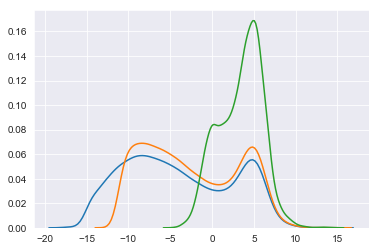

In [43]:

ax=sns.kdeplot(np.log2(np.mean(cpm_train,axis=0)))
ax=sns.kdeplot(np.log2(np.mean(cpm_train_expression_filter,axis=0)))
ax=sns.kdeplot(np.log2(np.mean(train_final,axis=0)))

## EDA

The objective of our EDA efforts were to explore each useful metadata field. The useful features included:
- Tissue origin (SMTS)
- Tissue sub-origin (SMTSD)
- Sex (SEX)
- Age (AGE)
- Death Classification Hardy Scale (DTHHRDY)

Our first task was to understand how many samples were from each tissue origin. This table shows how many samples are from each tissue. Interestingly, some of the lowest count tissues are sex organs. Some of the most collected tissues seem that they may have been easier to collect.

In [7]:
counts=pd.DataFrame(meta['SMTS'].value_counts())
display(counts)

,SMTS
Brain,1671
Skin,1203
Esophagus,1021
Blood Vessel,913
Adipose Tissue,797
Heart,600
Muscle,564
Blood,537
Colon,507
Thyroid,446


We then sought to explore how SMTSD,sub-tissue location, affects the samples. We generated PCA plots using the top 500 most variable genes following the logCPM transformation. The code for these plots can be found in `GTEx_input.R`. We found that SMTSD seems to account for the largest axis of variance for any tissue where STMSD is recorded. Representative plots from the blood and brain samples are shown.
![](progress_plots/Blood_Vessel_SMTSD_PCA.png)
![](progress_plots/Brain_SMTSD_PCA.png)

We then explored age, the primary dependent variable in our project. We found that many subjects did not have age recorded, affecting nearly 1500 samples.

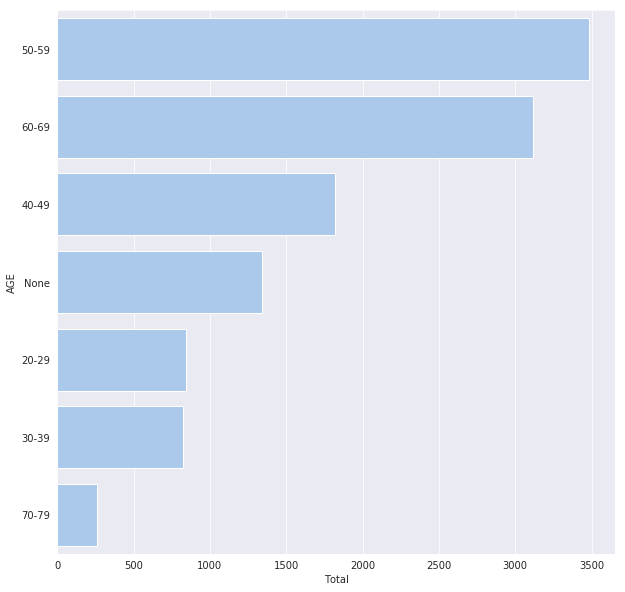

In [61]:
sns.set_color_codes("pastel")
AGE=meta['AGE'].copy()
AGE[AGE.isnull()]="None"
counts=pd.DataFrame({"AGE":AGE.value_counts()})
counts['Total']=counts['AGE']
counts['AGE']=counts.index.values
plt.figure(figsize=(10, 10))
ax=sns.barplot(x="Total", y="AGE", data=counts,
            label="Total", color="b")

We explored the gender feature (SEX) in the same way. We found that there are many more men than women in the data set. And again, there are nearly 1500 samples with sex recorded.

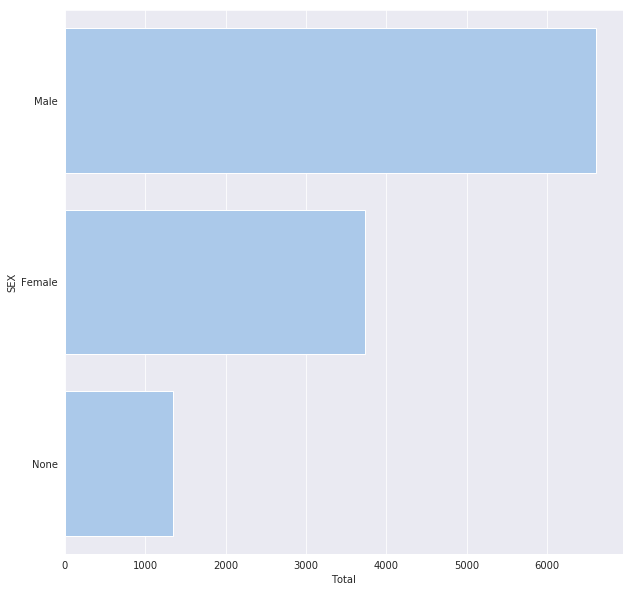

In [65]:
SEX=meta['SEX'].copy()
SEX[SEX.isnull()]="None"
counts=pd.DataFrame({"SEX":SEX.value_counts()})
counts['Total']=counts['SEX']
counts['SEX']=counts.index.values
counts['SEX'].replace({"1.0":"Male","2.0":"Female"},inplace=True)
plt.figure(figsize=(10, 10))
ax=sns.barplot(x="Total", y="SEX", data=counts,
            label="Total", color="b")

We found that library sizes (the total number of reads sequenced and aligned into counts) were generally around 10 million, which is good, but there are some outliers for each tissue. This plot shows the distribution of library sizes for Colon samples. Code for this plot can be viewed in `perTissue_models.ipynb`.
![](progress_plots/libsizeplot.png)

And finally we visualized the effect of the death classification with MDS plots from `Glimma` a specialized R package which utilizes `D3.js` to visualize RNA-seq data. We created MDS plots for every tissue, but the heart is particularly representative of the trends from the metadata features. The plot below can browsed interactively **[here](progress_plots/Heart/MDS-Plot.html)**.

A selected view shows that death classification has a major effect in the second and third dimension of MDS. There appears to be major differences between samples that died by vent or quickly by natural causes. This makes intuitive sense because dying while on a vent involves hypoxia. This trend persists for most tissues.
![](progress_plots/MDS.png)

## Visualization

We knew that some tissues had very few samples. To begin testing the relationships of the data, we needed to establish a threshold of minimum number of samples per tissue. This table shows the number of people in each age group.

In [28]:
df=meta[meta['SMTS'].isin(counts[counts['SMTS']>1].index)]
df=pd.crosstab(index=df['SMTS'],columns=df['AGE'])
sorted_i=df.sum(axis=1).sort_values(ascending=False).index.values
df=df.loc[sorted_i,:]
display(df)

AGE,20-29,30-39,40-49,50-59,60-69,70-79
SMTS,,,,,,
Skin,98,94,200,398,377,35
Esophagus,102,91,191,356,258,23
Blood Vessel,75,75,160,310,273,20
Adipose Tissue,57,66,131,273,245,25
Heart,33,29,95,220,205,18
Muscle,46,45,88,188,179,18
Blood,50,46,103,169,163,6
Colon,45,48,95,164,140,15
Thyroid,30,29,81,151,143,12


We also wanted to test whether there was differential gene expression on the basis of subject age for any tissue. Unfortunately, there are no tools in Python to accomplish the mean-dispersion estimation/transformation needed to run statistical tests on RNA-seq count data. Instead, we used `R` and the `edgeR`, `Limma`, and `Glimma` packages. 

## ML

Text

## Reflection

- The size of the data has been extremely prohibitive. The transformed counts are floats, which take much more space. It is best to compute the cpm transformation on the entire data set, meaning that we had to create these floats all in R before moving to Python.

## Next Steps

Text